# Машинное обучение

## Факультет математики НИУ ВШЭ

### 2018-2019 учебный год

Лектор: Илья Щуров

Семинаристы: Евгения Ческидова, Евгений Ковалев

Ассистенты: Константин Ваниев, Софья Дымченко

# Семинар 3

Сегодня мы узнаем

* Как работает метод ближайших соседей, какие у него есть параметры и на что они влияют.
* Что такое разложение ошибки на шум, смещение и разброс.
* Что такое кросс-валидация и какой она бывает.

# Метод k ближайших соседей

Метод k ближайших соседей (k nearest neighbours, k-NN) является одним из простейших алгоритмов машинного обучения. Несмотря на свою простоту, k-NN может превзойти более мощные алгоритмы и используется во множестве приложений, таких как экономическое прогнозирование, сжатие данных и генетика. Например, k-NN использовалась в [исследовании](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-S1-S11) по функциональной геномике в 2006 году, где гены определялись на основе их профилей экспрессии.

## Как работает k-NN?

Начнем с введения некоторых определений и обозначений.

* Пусть $x \in X$ — вектор признаков (или атрибутов) объекта. Обычно $X=\mathbb R^d$.
* Под $y$ мы будем подразумевать значение, которое мы хотим научиться предсказывать. Оно может быть числом (тогда говорят о *задаче регрессии*) или элементом конечного множества (*классом* или *меткой*, тогда говорят о *задаче классификации*). Например, предсказать выручку магазина по его месторасположению — это задача регрессии, а определить, болен человек некоторой конкретной болезнью или нет — задача классификации.

k-NN входит в число **supervised** алгоритмов или алгоритмов «обучения с учителем».
Это означает, что нам предоставляется набор данных $(x_1, y_1), \ldots, (x_n, y_n)$, в котором приведены признаки и верные ответы для $n$ каких-то объектов. Целью является на основе предоставляемой выборки найти связь между $x$ и $y$, то есть восстановить функцию $h: X \rightarrow Y$. Имея такую функцию, мы можем предсказать $y$ по имеющемуся наблюдению $x$.

Для нового объекта с вектором признаков $x_{new}$ алгоритм k-NN находит $k$ ближайших к $x_{new}$ точек среди $x_1, \ldots, x_n$. Пусть они имеют индексы $i_1, \ldots, i_k$. Для задачи регрессии в качестве $h(x)$ используется среднее соответствующих значений $y$, то есть

$$h(x)=\frac{1}{k}\sum_{i=1}^k y_{i_k}.$$

Для задачи классификации в качестве $h(x)$ используется то значение $y$, которое встречается среди $y_{i_1}, \ldots, y_{i_k}$ чаще всего (если таких значений несколько, выбирается какое-то одно из них — например, самое маленькое для какого-то порядка на классах).

## Реализация k-NN вручную

Чтобы лучше понять, как работает kNN, реализуем его «вручную». Наша реализация будет довольно неэффективной — для реальной работы мы будем использовать реализацию в библиотеке scikit-learn, которая использует хитрые структуры данных для быстрого поиска ближайшего соседа. Мы же будем банально сортировать все элементы по близости к новому и выбирать k самых близких. Это дико неэффективно, но зато понятно, как работает.

In [3]:
import numpy as np

In [11]:
x_train = np.array([[1, 1], [0, 0], [0, 1]])
x_new = np.array([0, 1])

In [12]:
x_train - x_new

array([[ 1,  0],
       [ 0, -1],
       [ 0,  0]])

In [13]:
# находим расстояния до элементов x_train;
# в качестве расстояния используется евклидова норма разности векторов
distances = np.linalg.norm(x_train - x_new, axis=1)
distances

array([1., 1., 0.])

In [14]:
# сортируем по возрастанию, т.е. первый элемент массива -- индекс ближайшего элемента к x_new
np.argsort(distances)

array([2, 0, 1])

In [15]:
def kNN_regression(x_train, y_train, x_new, k=1):
    """
    x_train is np.array with shape (n, d) (matrix with n rows, d columns)
    y_train is np.array with shape (n, ) (1-dimensional array with n elements)
    x_new is np.array with shape (d,) (1-dimensional array with d elements)
    """
    distances = np.linalg.norm(x_train - x_new, axis=1)
    # вычислить расстояние между каждой строкой x_train и x_new
    # x_train - x_new создаёт новую матрицу, получаемую 
    # вычитанием x_new из каждой строки x_train в силу broadcasting rules
    # x_new broadcast'ится из shape (d,) до shape (n, d) путём повторения
    # дальше np.linalg.norm вычисляет норму каждой строки получившейся матрицы
    # если бы было axis=0, то она вычисляла бы норму каждого столбца
    
    sorted_idxs = np.argsort(distances)
    # np.argsort(distances) возвращает индексы вектора distances 
    # в порядке возрастания элементов
    
    return y_train[sorted_idxs[:k]].mean()
    # вырали y'и соответствующие k самым маленьким расстояниям и усреднили

## Синтезированные данные
Посмотрим, как работает k-NN на примере синтезированных данных. Пусть реальная зависимость $y$ и $x$ задаётся правилом $y=x^2+\varepsilon$, где $\varepsilon$ — некоторый шум с нулевым матожиданием.

Точнее, мы будем рассматривать следующую модель:

\begin{gather}
X \sim Uniform(-1, 1);\\
\varepsilon \sim \mathcal N(0, \varepsilon_0)\\
Y = X^2 + \varepsilon,
\end{gather}

где $Uniform(-1, 1)$ — равномерное распределение на отрезке $[-1, 1]$, переменные $X$ и $\varepsilon$ независимы.

In [16]:
def f(x):
    return x ** 2
def make_data(n, eps0):

    X = np.random.uniform(low=-1, high=1, size=(n, 1))
    eps = np.random.normal(scale=eps0, size=(n, 1))

    Y = (f(X) + eps)[:, 0]
    # чтобы Y был одномерным, выбрали первый (он же единственный) столбец
    # с помощью [:, 0]
    
    return X, Y

In [17]:
X, Y = make_data(30, 0.1)

In [18]:
X

array([[-0.9490238 ],
       [ 0.35539328],
       [-0.30639104],
       [ 0.37887369],
       [-0.5729549 ],
       [-0.66331639],
       [ 0.24894988],
       [-0.91035025],
       [ 0.14702536],
       [ 0.70754964],
       [-0.67731057],
       [-0.21107954],
       [ 0.63300895],
       [-0.91815264],
       [-0.68911027],
       [ 0.75097875],
       [ 0.45905133],
       [ 0.52129981],
       [ 0.15238626],
       [ 0.92916345],
       [-0.43462485],
       [-0.43035915],
       [-0.04769386],
       [ 0.49499049],
       [ 0.33912465],
       [-0.06035411],
       [-0.40245053],
       [ 0.67613115],
       [-0.79410976],
       [-0.63999655]])

In [19]:
Y

array([ 0.92302165,  0.05528283,  0.10888551,  0.16794457,  0.24190874,
        0.47691307,  0.08348806,  0.80626232, -0.10853109,  0.66068765,
        0.40384478, -0.20942326,  0.36798566,  0.98316409,  0.58189466,
        0.38575542,  0.34352269,  0.24494343,  0.14690266,  0.8962344 ,
        0.36375873,  0.20622827, -0.14850717,  0.21066999,  0.11596762,
       -0.05062921,  0.37150624,  0.36782487,  0.54902649,  0.39621089])

In [20]:
X.shape

(30, 1)

In [21]:
Y.shape

(30,)

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'Y')

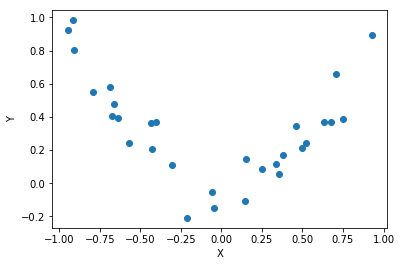

In [23]:
plt.plot(X[:, 0], Y, 'o', label="data")
plt.xlabel("X")
plt.ylabel("Y")

Как обсуждалось на лекции, наилучшим предсказанием $y$ для данного $x$ с точки зрения минимизации ожидаемой ошибки для квадратичной функции потерь является условное матожидание $E[Y\mid X=x]$. Для нашей модели

$$E[Y\mid X=x]=x^2.$$

Text(0,0.5,'Y')

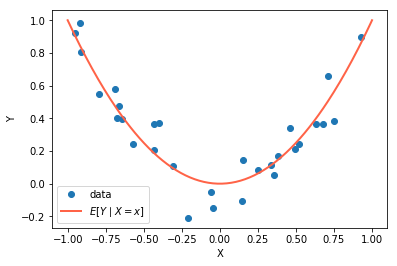

In [24]:
plt.plot(X[:, 0], Y, 'o', label="data")
x_grid = np.linspace(-1, 1, 200)
plt.plot(x_grid, f(x_grid), color='tomato', lw=2, label="$E[Y\mid X=x]$")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")

### Эффект от изменения $k$ 

Посмотрим, как работает k-NN для наших данных.

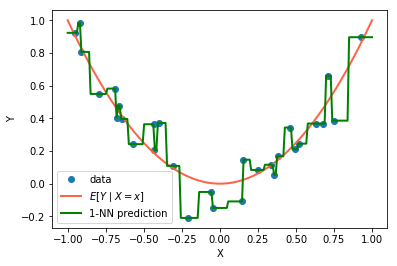

In [25]:
def plot_kNN(X, Y, k, **kwargs):
    plt.plot(X[:, 0], Y, 'o', label="data", **kwargs)
    x_grid = np.linspace(-1, 1, 200)
    plt.plot(x_grid, f(x_grid), color='tomato', lw=2, label="$E[Y\mid X=x]$")
    plt.plot(x_grid, [kNN_regression(X, Y, x_new, k) for x_new in x_grid], 
             'g-', label="{}-NN prediction".format(k), lw=2)
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
plot_kNN(X, Y, 1)

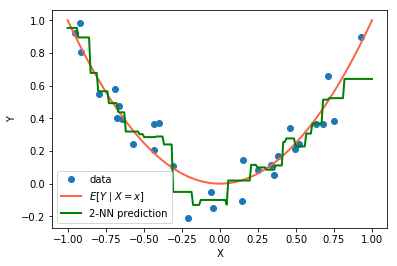

In [26]:
plot_kNN(X, Y, 2)

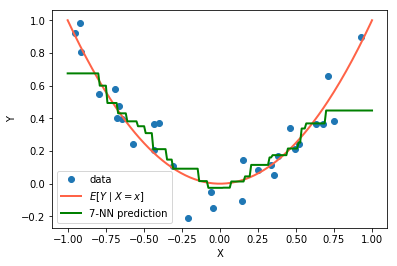

In [27]:
plot_kNN(X, Y, 7)

Что будет, если увеличить количество данных?

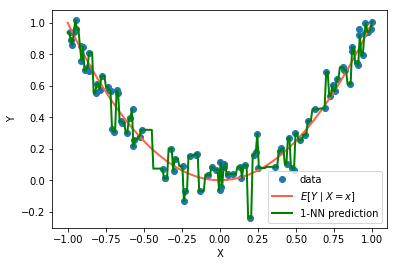

In [28]:
X, Y = make_data(100, 0.1)
plot_kNN(X, Y, 1)

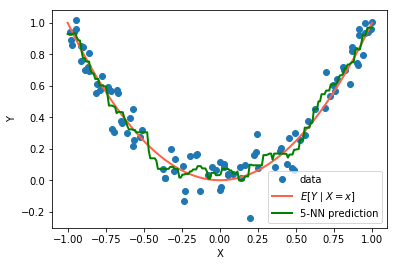

In [29]:
plot_kNN(X, Y, 5)

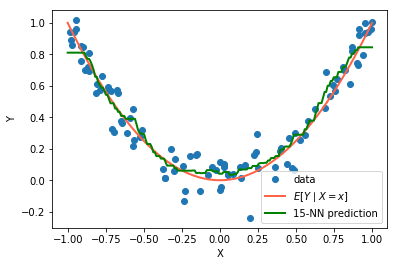

In [30]:
plot_kNN(X, Y, 15)

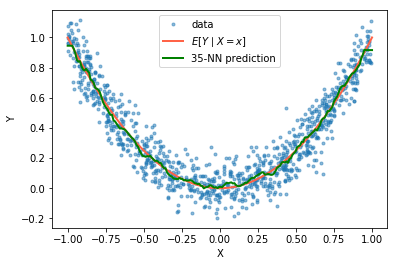

In [31]:
X, Y = make_data(1000, 0.1)
plot_kNN(X, Y, 35, markersize=3, alpha=0.5)

**Теорема**. Если $f(x)=E[Y\mid X=x]$ является непрерывной функцией от $x$, при некоторых дополнительных условиях, k-NN-регрессия даёт состоятельную оценку для $f(x)$ при $k, N \to \infty$, т.ч. $k/N\to 0$.

**Основная идея:** если данных очень много, то можно выбрать такое большое $k$, которое было бы при этом мало по сравнению с $N$. При этом $k$ ближайших соседей для точки $x_{new}$ будут лежать очень близко к ней, и, за счёт того, что $k$ большое, k-NN оценка будет достаточно близкой к истинному матожиданию $f(x_{new})$.

### Смещенность k-NN-оценки

Мы считаем наши данные $(x_1, y_1), \ldots, (x_n, y_n)$ результатом независимых реализаций случайной величины $(X, Y)$. Алгоритм машинного обучения (например, k-NN) обучается на данных и его ответы зависят от того, какие данные он «увидел». Следовательно, ответы алгоритма для фиксированного $x_{new}$ также являются результатом реализации случайной величины. 

Чтобы увидеть это наглядно, сгенерируем несколько разных выборок из одного и того же распределения, обучим на каждом kNN-регрессию и построим графики предсказаний.

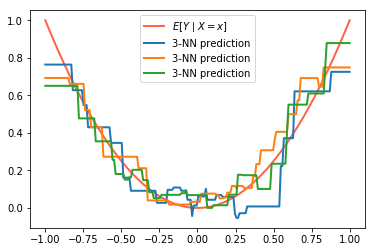

In [37]:
x_grid = np.linspace(-1, 1, 200)
plt.plot(x_grid, f(x_grid), color='tomato', lw=2, label="$E[Y\mid X=x]$")
k = 3
for i in range(3):
    X, Y = make_data(30, 0.1)
    plt.plot(x_grid, [kNN_regression(X, Y, x_new, k) for x_new in x_grid], 
             label="{}-NN prediction".format(k), lw=2)
plt.legend()
plt.show()

Нас будет интересовать матожидание предсказания: мы хотим понять, является ли k-NN-оценка несмещённой для истинной зависимости $y=f(x)$.

Чтобы дать ответ на этот вопрос, сделаем следующее. Сгенерируем выборку много раз. Каждый раз будем обучать алгоритм на новой выборке и запрашивать предсказание для каких-то значений $x_{new}$. Запомним предсказания, а затем усредним их.

Для ускорения работы мы будем использовать готовый kNN из библиотеки scikit-learn вместо нашего самописного. Помимо прочего, он умеет находить предсказания сразу для массива значений $x$.

In [68]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=10)

gridpoints = 200
n = 30
samples = 1000

x_grid = np.linspace(-1, 1, gridpoints).reshape(-1, 1)
predictions = np.empty((gridpoints, samples))
for i in range(samples):
    X, Y = make_data(n, 0.1)
    knn.fit(X, Y)
    predictions[:, i] = knn.predict(x_grid)

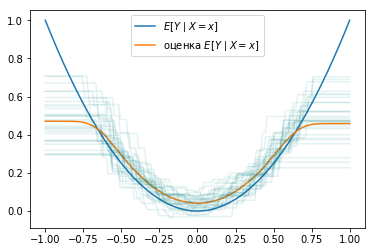

In [69]:
plt.plot(x_grid, f(x_grid), label='$E[Y\mid X=x]$')
plt.plot(x_grid, predictions.mean(axis=1), label='оценка $E[Y\mid X=x]$')
for i in range(30):
    plt.plot(x_grid, predictions[:, i], alpha=0.1, color='teal')
plt.legend()
plt.show()

**Вопросы**

1. Является ли k-NN оценка несмещнной оценкой для $E[y\mid X=x]$ согласно результатам экспериментов? Как вы можете это объяснить?
2. Как зависит степень смещённости от $k$ при фиксированном количестве данных? Почему?
3. Как зависит степень смещённости от количества данных ($n$) при фиксированном $k$? Почему?
3. Как будет выглядеть картинка, если взять $f(x)=\sin 5x$? В каких точках матожидание оценок будет больше истинного матождиания, в каких меньше? Почему? (Запрограммируйте и объясните.)

In [220]:
# YOUR CODE HERE

### Разброс k-NN оценки
Помимо смещённости нас также интересует дисперсия (разброс) предсказаний, которые даёт k-NN. Модифицируйте код выше таким образом, чтобы он строил график разброса (несколько графиков разброса, соответствующих разным значениям $k$). Как влияет $k$ на разброс?

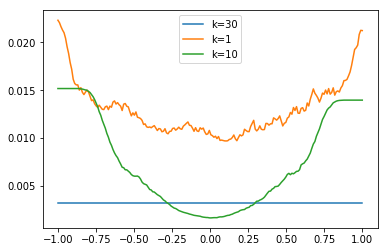

In [77]:
# YOUR CODE HERE

## Разложение ожидаемой ошибки на шум, смещение и разброс


<img src="https://qph.fs.quoracdn.net/main-qimg-a222c081325070d06d64966c68359283-c" width="360" align="center">

Почему нас так интересует смещённость и разброс предсказаний? Оказывается, они определяют, насколько сильно будет ошибаться алгоритм. Пусть $(x_{data}, y_{data})$ — обучающая выборка, $(x_{new}, y_{new})$ — новая точка, полученная из того же распределения $(X, Y)$, $a(x_{data}, y_{data})$, алгоритм, обученный на данной выборке, $a(x_{data}, y_{data})(x_{new})$ — его предсказание в точке $x_{new}$. На следующей лекции мы докажем, что ожидаемую среднеквадратичную ошибку предсказания для произвольной точки $x_{new}$ можно разложить на три компоненты следующим образом:

\begin{align}
\mathbb E[(a(x_{data}, y_{data})(x_{new})-y_{new})^2]  = & \mathbb E[(y_{new}-\mathbb E[y_{new}])^2] +\\
(&\mathbb E[a(x_{data}, y_{data})(x_{new})]-\mathbb E[y_{new}])^2+\\
& \mathbb E[(a(x_{data}, y_{data})(x_{new}) - \mathbb E[a(x_{data}, y_{data})(x_{new})])^2].
\end{align}

Во всех матожиданиях $y_{new}$ выбирается из условного  распределения $Y\mid X=x_{new}$.

Первое слагаемое называется «*шумом*» (noise). Оно показывает, насколько сильно ответы $y_{new}$ отличаются от своих средних значений («идеальных предсказаний»). Мы не могли бы сделать ожидаемую ошибку меньше шума, даже если бы знали истинное распределение $(X, Y)$.

Второе слагаемое — это *смещение* (bias) нашей оценки. Оно показывает, насколько сильно средний ответ алгоритма (усреднение происходит по разным обучающим выборкам) отличается от «идеального предсказания» $\mathbb E[Y \mid X=x_{new}]$.

Наконец, третье слагаемое называется *разбросом*. Это дисперсия предсказания. Она показывает, насколько разные мы можем получать предсказания при обучении алгоритма на разных выборках, взятых из одного и того же распределения. Иными словами, оно показывает, насколько чувствителен наш алгоритм к данным.

**Вопрос.** В соответствии с результатами, полученными ранее, что вы можете сказать о выборе оптимального $k$ для k-NN? Правда ли, что $k$ нужно делать как можно больше, чтобы уменьшить разброс предсказаний? Правда ли, что $k$ нужно делать как можно меньше, чтобы уменьшить смещение предсказаний?

### kNN для задачи классификации
Напишите функцию `kNN_classifier(x_train, y_train, x_new, k=1)` по аналогии с `kNN_regression`. Вместо взятие среднего нужно выбрать значение $y$, которое встречается среди $k$ ближайших соседей чаще всего. (Подсказка: оно называется *модой*.)

In [218]:
def kNN_classifier(x_train, y_train, x_new, k=1):
    # YOUR CODE HERE
    pass

## Эксперименты с реальными данными

Теперь рассмотрим как работает уже готовый классификатор из scikit-learn на примере датасета с разными видами стекла.

Подробнее о датасете тут: [kaggle_dataset_link](https://www.kaggle.com/uciml/glass)

In [211]:
import pandas as pd
import numpy as np

In [212]:
data = pd.read_csv("./data/glass.csv")
print("Размерность данных: {}\n".format(data.shape))
data.head()

Размерность данных: (214, 10)



,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Сколько есть видов стекла в нашем датасете?

In [213]:
data.Type.unique()

array([1, 2, 3, 5, 6, 7])

Посмотрим на распределения признаков по разным классам;

Рассмотрим для начала небольшую подвыборку признаков просто для удобства отрисовки.

In [214]:
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


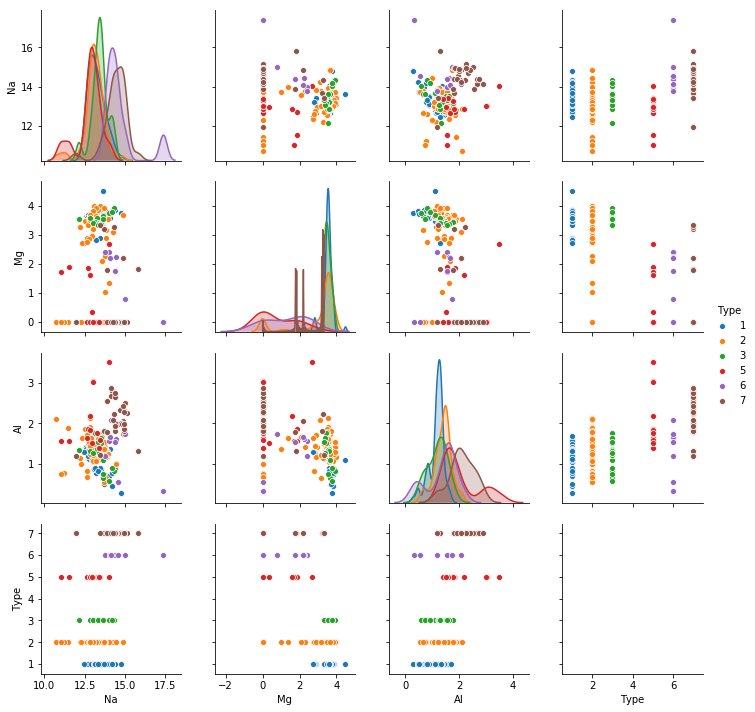

In [215]:
sns.pairplot(data.iloc[:, [1,2,3,-1]], hue='Type')

Видно, что не находится такой пары признаков, в координатах которых типы стекол легко бы разделялись. Также видно, что датасет неуравновешен и есть большой перекос в количестве примеров в сторону 1 и 2 классов. Однако в случае использования kNN для нас это не является большой проблемой. Почему?

Теперь мы можем обучить алгоритм kNN на наших данных.

In [245]:
X, y = data.iloc[:, :-1], data.Type
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

Можно использовать обученную модель для предсказаний на новых данных.

In [248]:
new_data = pd.DataFrame([[1.5, 12.3, 4.2, 1.3, 72.7, 0.57, 7.4, 0, 0]])
# числа написаны произвольным образом
knn.predict(new_data)

array([2])

Как можно проверить, насколько хорошо алгоритм работает? Если бы у нас была возможность получить новые данные (с ответами), мы могли бы попросить наш алгоритм сделать предсказания на них и сравнить результаты с ответами. Однако, новые данные взять неоткуда. Можно попросить алгоритм предсказать ответ на каких-нибудь данных, на которых он и обучался.

**Вопрос.** При каком $k$ метод kNN будет лучше всего предсказывать ответы для тех элементов, на которых он обучался? Какой результат получится? Обязательно ли это свидетельствует о качестве нашего алгоритма?

Как видимо, проверять работу обученного алгоритма на тех данных, на которых он обучался, не имеет смысла. Как же быть? На помощь приходит кросс-валидация. 

## Кросс-валидация (Скользящий контроль)

**Терминология**
<img src="http://www.vias.org/tmdatanaleng/img/hl_crossval.png" width="400" align="center">

**Оценкой скользящего контроля** называется средняя по всем разбиениям величина ошибки на контрольных подвыборках.

Если выборка независима, то средняя ошибка скользящего контроля даёт несмещённую оценку вероятности ошибки.

Выделяют следующие виды скользящего контроля

* *Контроль на отложенных данных* (**hold-out CV**)
    - Оценка производится по одному случайному разбиению 
* *Контроль по отдельным объектам* (**leave-one-out CV**)
    - Поочередно из выборки убирается один объект, модель обучется на оставшейся выборке и делает предсказание на отложенном объекте.
* *Контроль по $q$ блокам (**q-fold CV**)*
    - Выборка случайным образом разбивается на $q$ непересекающихся блоков одинаковой (или почти одинаковой) длины.
* *Контроль по $r×q$ блокам (**r×q-fold CV**)*
    - Контроль по $q$ блокам (q-fold CV) повторяется $r$ раз. Каждый раз выборка случайным образом разбивается на $q$ непересекающихся блоков. Этот способ наследует все преимущества $q$-fold CV, при этом появляется дополнительная возможность увеличивать число разбиений.

Подробнее про каждый из них и про доверительные интервалы для оценок результатов кросс-валидации можно почитать [здесь](http://www.machinelearning.ru/wiki/index.php?title=Скользящий_контроль).

Еще один важный термин

**Стратификация** заключается в том, чтобы заранее поделить выборку на части (страты), и при разбиении на обучение длины $m$ и контроль длины $k$ гарантировать, что каждая страта будет поделена между обучением и контролем в той же пропорции $m:k$.

**Стратификация классов в задачах классификации** означает, что каждый класс (который и определяет страту) делится между обучением и контролем в пропорции $m:k$, где $m$ — размер обучающей выборки, а $k$ — размер тестовой выборки при данном варианте разбиения.
Стратификация позволяет уменьшить разброс оценок скользящего контроля и сузить доверительные интервалы для них.

# sklearn

В sklearn есть встроенные средства для деления датасета на обучение и тест. Вообще, все там есть.

In [262]:
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     StratifiedKFold, KFold)

# стратификация согласно разметке по классам
# деление датасета на обучение и тест один раз
# это и есть hold-out CV
# как правило при таком подходе k-fold cv производится отдельно над train частью датасета
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=42, 
                                                    stratify=data.Type)

Обучим модель на train части и проверим на тестовой.

In [263]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [264]:
y_pred = knn.predict(X_test)

In [265]:
y_pred

array([7, 7, 1, 7, 2, 2, 7, 2, 2, 7, 1, 3, 1, 6, 2, 2, 1, 7, 5, 7, 1, 5,
       7, 1, 1, 3, 6, 1, 2, 7, 1, 7, 5, 1, 3, 2, 2, 1, 1, 2, 2, 1, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 7, 2, 2, 2, 2,
       2, 1, 2, 1, 1])

In [270]:
y_test

196    7
206    7
148    3
172    5
84     2
139    2
199    7
2      1
132    2
203    7
61     1
95     2
23     1
179    6
128    2
129    2
48     1
194    7
169    5
204    7
24     1
201    7
193    7
144    2
147    3
60     1
176    6
151    3
59     1
208    7
      ..
94     2
77     2
1      1
51     1
29     1
65     1
52     1
141    2
32     1
41     1
20     1
131    2
114    2
11     1
43     1
86     2
120    2
157    3
70     2
80     2
171    5
93     2
113    2
110    2
117    2
122    2
66     1
76     2
21     1
26     1
Name: Type, Length: 71, dtype: int64

In [267]:
(y_pred == y_test).mean()

0.6901408450704225

In [268]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.6901408450704225

In [224]:
# реализация q-fold cv со стратификацией по параметру y

kfold_iterator = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in kfold_iterator.split(X,y):
    print("TRAIN:", train_index[:5], "TEST:", test_index[:5])
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [24 25 26 27 28] TEST: [0 1 2 3 4]
TRAIN: [0 1 2 3 4] TEST: [24 25 26 27 28]
TRAIN: [0 1 2 3 4] TEST: [47 48 49 50 51]


Другие виды кросс-валидации также доступны и с ними можно ознакомиться [здесь](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)

## Исследуем KNN из коробки

KNN имеет следующие важные параметры, которые напрямую затрагивают результаты предсказания

- `weights`
- `n_neighbors`
    
Прочитайте в документации про них подробнее.

In [225]:
from matplotlib import pyplot as plt

In [226]:
from sklearn.neighbors import KNeighborsClassifier

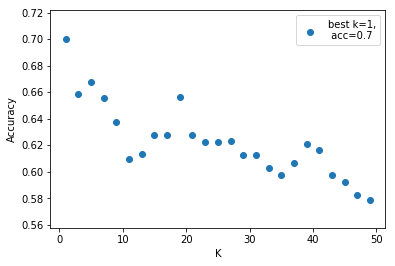

In [227]:
# выбираем только нечетные значения k от 1 до 50
neighbors = np.arange(1, 50, 2)

# сюда мы сложим наши скоры
cv_scores = []

kf = StratifiedKFold(n_splits=7, random_state=42, shuffle=True)

# выполним кросс-валидацию на 7 фолдах со стратификацией,
# в качестве метрики возьмем простое accuracy
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    scores = cross_val_score(knn, X, y, cv=kf, scoring='accuracy',)
    cv_scores.append(scores.mean())
    
# отрисуем полученный результат
plt.scatter(neighbors, cv_scores, label='best k={},\n acc={}'.format(neighbors[np.argmax(cv_scores)],
                                                               np.round(max(cv_scores),2)), )
plt.ylabel("Accuracy")
plt.legend()
plt.xlabel("K")
plt.show()

# Задания
### Проведите эксперименты, чтобы ответить на следующие вопросы:

**>>Весь код экспериментов должен быть выполнен в ячейках ниже задания с пометкой c номером задания**


1. Проведите эксперименты с одинаковым разбиением для cv, но различными значениями параметра weights у KNN.
Постройте 3 графика в одних координатах: для значений `uniform`, `distance`, ваша кастомная функция. Сделайте вывод о влиянии этих параметров на предсказание модели для данной задачи.


2. Постройте зависимость разброса предсказаний модели от $k$. В качестве cv возьмите `StratifiedKFold` c `n_splits=7`. Опишите свои наблюдения, сделайте выводы. 

3. Воспользуйтесь датасетом, определенным в следующей ячейке (в дальнейшем датасет#2). Разбейте его на трейн и тест с `random_state=42`, `test_size=0.3`, `stratify` по `y`.
Поэкспериментируйте с различными вариантами cv на трейн части и постарайтесь выбрать наилучшие параметры knn.
После того, как параметры будут подобраны обучите модель на всей train выборки и сделайте с ее помощью предсказание на тесте. Какое наилучшее значение accuracy у вас получилось на тест части и при каких параметрах knn?


# Самостоятельная часть

Для задания **#1**

In [ ]:
<your code here>

Для задания **#2**

In [ ]:
<your code here>

Для задания **#3**

In [68]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

# датасет#2
X,y = make_classification(n_samples=1000, n_features=500, n_informative=359, 
                          n_classes=2)

In [72]:
X_train, X_test, y_train, y_test = ...
<your code>
accuracy_score(y_test, prediction)